In [1]:
import csv, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, matplotlib as mpl

In [2]:
with open('scrapedprices.csv','r') as f:
    reader = csv.reader(f)
    df = pd.DataFrame(reader)
    
df.columns = df.iloc[0] #Set column names
df = df[1:]
df['price'] = pd.to_numeric(df['price'])
df.head()

,drug,city,name,address,price
1,ALBUTEROL SULFATE,Atlanta,WALMART PHARMACY,"835 Martin Luther King Jr Dr NW\nAtlanta, GA 3...",6.76
2,ALBUTEROL SULFATE,Atlanta,PUBLIX PHARMACY,"905 Memorial Dr SE\nAtlanta, GA 30316",6.78
3,ALBUTEROL SULFATE,Atlanta,KROGER PHARMACY,"800 Glenwood Ave SE\nAtlanta, GA 30316",6.88
4,ALBUTEROL SULFATE,Atlanta,WALGREENS,"25 Peachtree St SE\nAtlanta, GA 30303",8.83
5,ALBUTEROL SULFATE,Atlanta,"COMMUNITY, A WALGREENS PHARMACY","565 Peachtree St NE Ste B\nAtlanta, GA 30308",8.83


In [3]:
with open('rx_spend_by_country.csv', 'r', encoding='utf-8-sig') as f:
    reader = csv.reader(f)
    rx_spend = pd.DataFrame(reader)

rx_spend.columns = rx_spend.iloc[0] #Set column names
rx_spend = rx_spend[1:]
rx_spend['Value'] = pd.to_numeric(rx_spend['Value'])

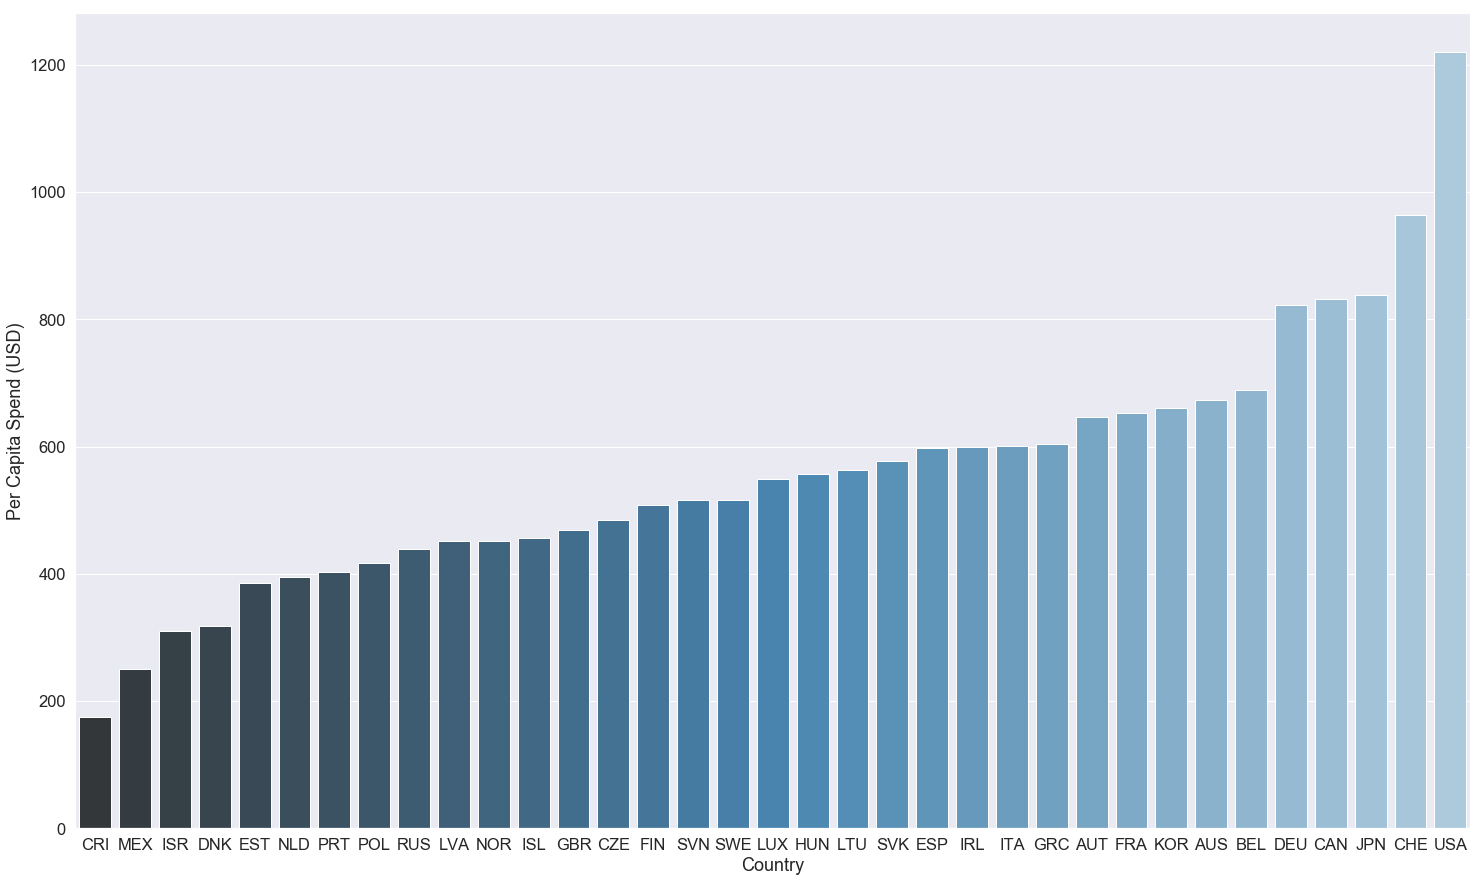

In [4]:
# Create barplot of prescription drug spend by country
bar_order = rx_spend.groupby(['Country']).mean().sort_values(by='Value').index
plt.figure(figsize = (25,15))
sns.set(font_scale=1.5)
ax = sns.barplot(x='Country', y='Value', data=rx_spend, order=bar_order, palette='Blues_d')
ax.set(xlabel='Country', ylabel='Per Capita Spend (USD)')

plt.show()

In [5]:
with open('drug_list.csv','r',encoding='utf-8-sig') as f:
    reader = csv.reader(f)
    drug_list = pd.DataFrame(reader)

drug_list.columns = drug_list.iloc[0]
drug_list = drug_list[1:]
    
drug_list['weight'], drug_list['count'] = pd.to_numeric(drug_list['weight']), pd.to_numeric(drug_list['count'])
drug_list['wellrx_qty'] = pd.to_numeric(drug_list['wellrx_qty'])
drug_list['nadac_unit_price'] = pd.to_numeric(drug_list['nadac_unit_price'])

df = df.merge(drug_list, how='inner', left_on='drug', right_on='drug_name')

df['wellrx_unit_price'] = df['price']/df['wellrx_qty']
df['nadac_savings'] = (df['wellrx_unit_price'] - df['nadac_unit_price'])/df['wellrx_unit_price']
df['adj_wellrx_price'] = df['weight'] * df['wellrx_unit_price']
df['adj_nadac_price'] = df['weight'] * df['nadac_unit_price']

df.head()

,drug,city,name,address,price,drug_name,wellrx_qty,wellrx_dosage,nadac_unit_price,count,weight,wellrx_unit_price,nadac_savings,adj_wellrx_price,adj_nadac_price
0,ALBUTEROL SULFATE,Atlanta,WALMART PHARMACY,"835 Martin Luther King Jr Dr NW\nAtlanta, GA 3...",6.76,ALBUTEROL SULFATE,225,2.5 MG/3ML Vial,0.03929,47110,0.034688,0.030044,-0.307729,0.001042,0.001363
1,ALBUTEROL SULFATE,Atlanta,PUBLIX PHARMACY,"905 Memorial Dr SE\nAtlanta, GA 30316",6.78,ALBUTEROL SULFATE,225,2.5 MG/3ML Vial,0.03929,47110,0.034688,0.030133,-0.303872,0.001045,0.001363
2,ALBUTEROL SULFATE,Atlanta,KROGER PHARMACY,"800 Glenwood Ave SE\nAtlanta, GA 30316",6.88,ALBUTEROL SULFATE,225,2.5 MG/3ML Vial,0.03929,47110,0.034688,0.030578,-0.284920,0.001061,0.001363
3,ALBUTEROL SULFATE,Atlanta,WALGREENS,"25 Peachtree St SE\nAtlanta, GA 30303",8.83,ALBUTEROL SULFATE,225,2.5 MG/3ML Vial,0.03929,47110,0.034688,0.039244,-0.001161,0.001361,0.001363
4,ALBUTEROL SULFATE,Atlanta,"COMMUNITY, A WALGREENS PHARMACY","565 Peachtree St NE Ste B\nAtlanta, GA 30308",8.83,ALBUTEROL SULFATE,225,2.5 MG/3ML Vial,0.03929,47110,0.034688,0.039244,-0.001161,0.001361,0.001363


In [6]:
from scipy.stats import zscore
df['zscore'] = df.groupby(['drug']).wellrx_unit_price.transform(lambda x : zscore(x))
df['mean_wellrx_unit_price'] = df.groupby(['drug']).wellrx_unit_price.transform(np.mean)
df1 = df.loc[abs(df['zscore']) < 3] # Remove outliers

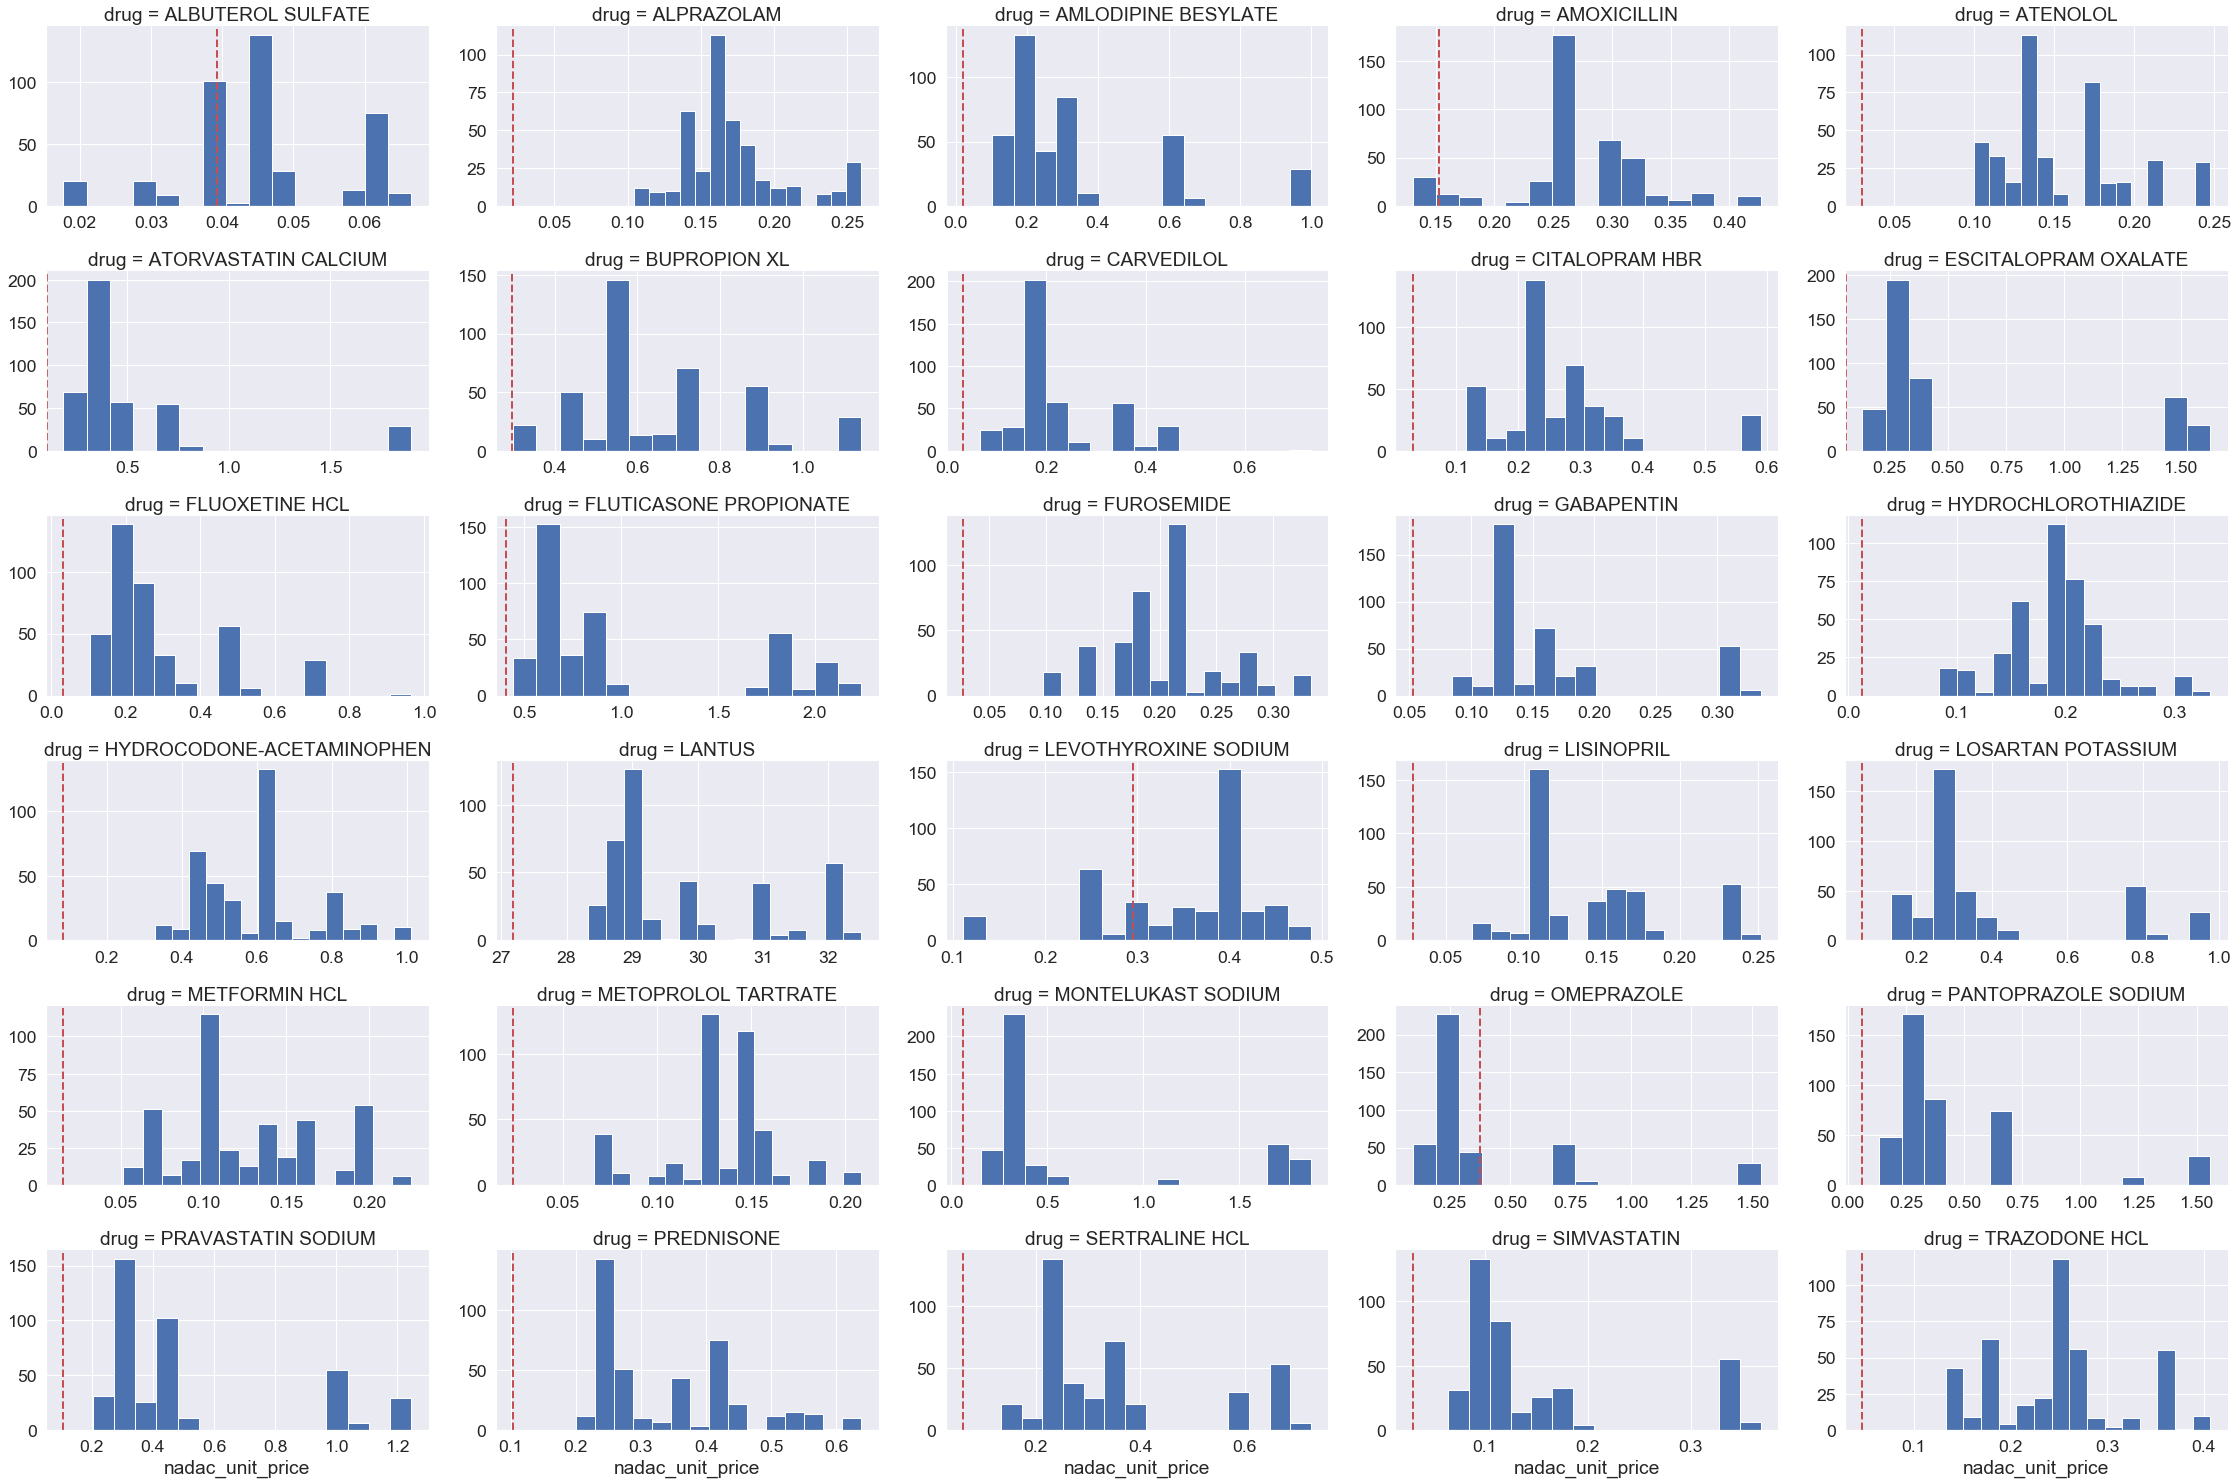

In [7]:
# Add in NADAC price lines and plot in seaborn

def vertical_mean_line(x, **kwargs):
    plt.axvline(x.mean(), color='r', ls='--', lw=2)
    
sns.set(font_scale=1.6)
g = sns.FacetGrid(df1, col='drug', col_wrap=5, sharex=False, sharey=False, height=3.5, aspect=1.8)
g.map(plt.hist, 'wellrx_unit_price', bins=15)
g.map(vertical_mean_line, 'nadac_unit_price')

In [8]:
pharm_index = df1.groupby(['name']).size().sort_values(ascending=False).index[:20]
temp = df1.groupby(['name']).mean()['zscore']
pd.DataFrame(temp[temp.index.isin(pharm_index)].sort_values())

,zscore
name,
PUBLIX PHARMACY,-1.165130
KROGER PHARMACY,-1.038581
FRED MEYER PHARMACY,-0.986879
WINN DIXIE,-0.939158
HEB PHARMACY,-0.839354
HARRIS TEETER PHARMACY,-0.755353
WALMART PHARMACY,-0.726488
RALPHS PHARMACY,-0.629312
BENZER PHARMACY,-0.212880


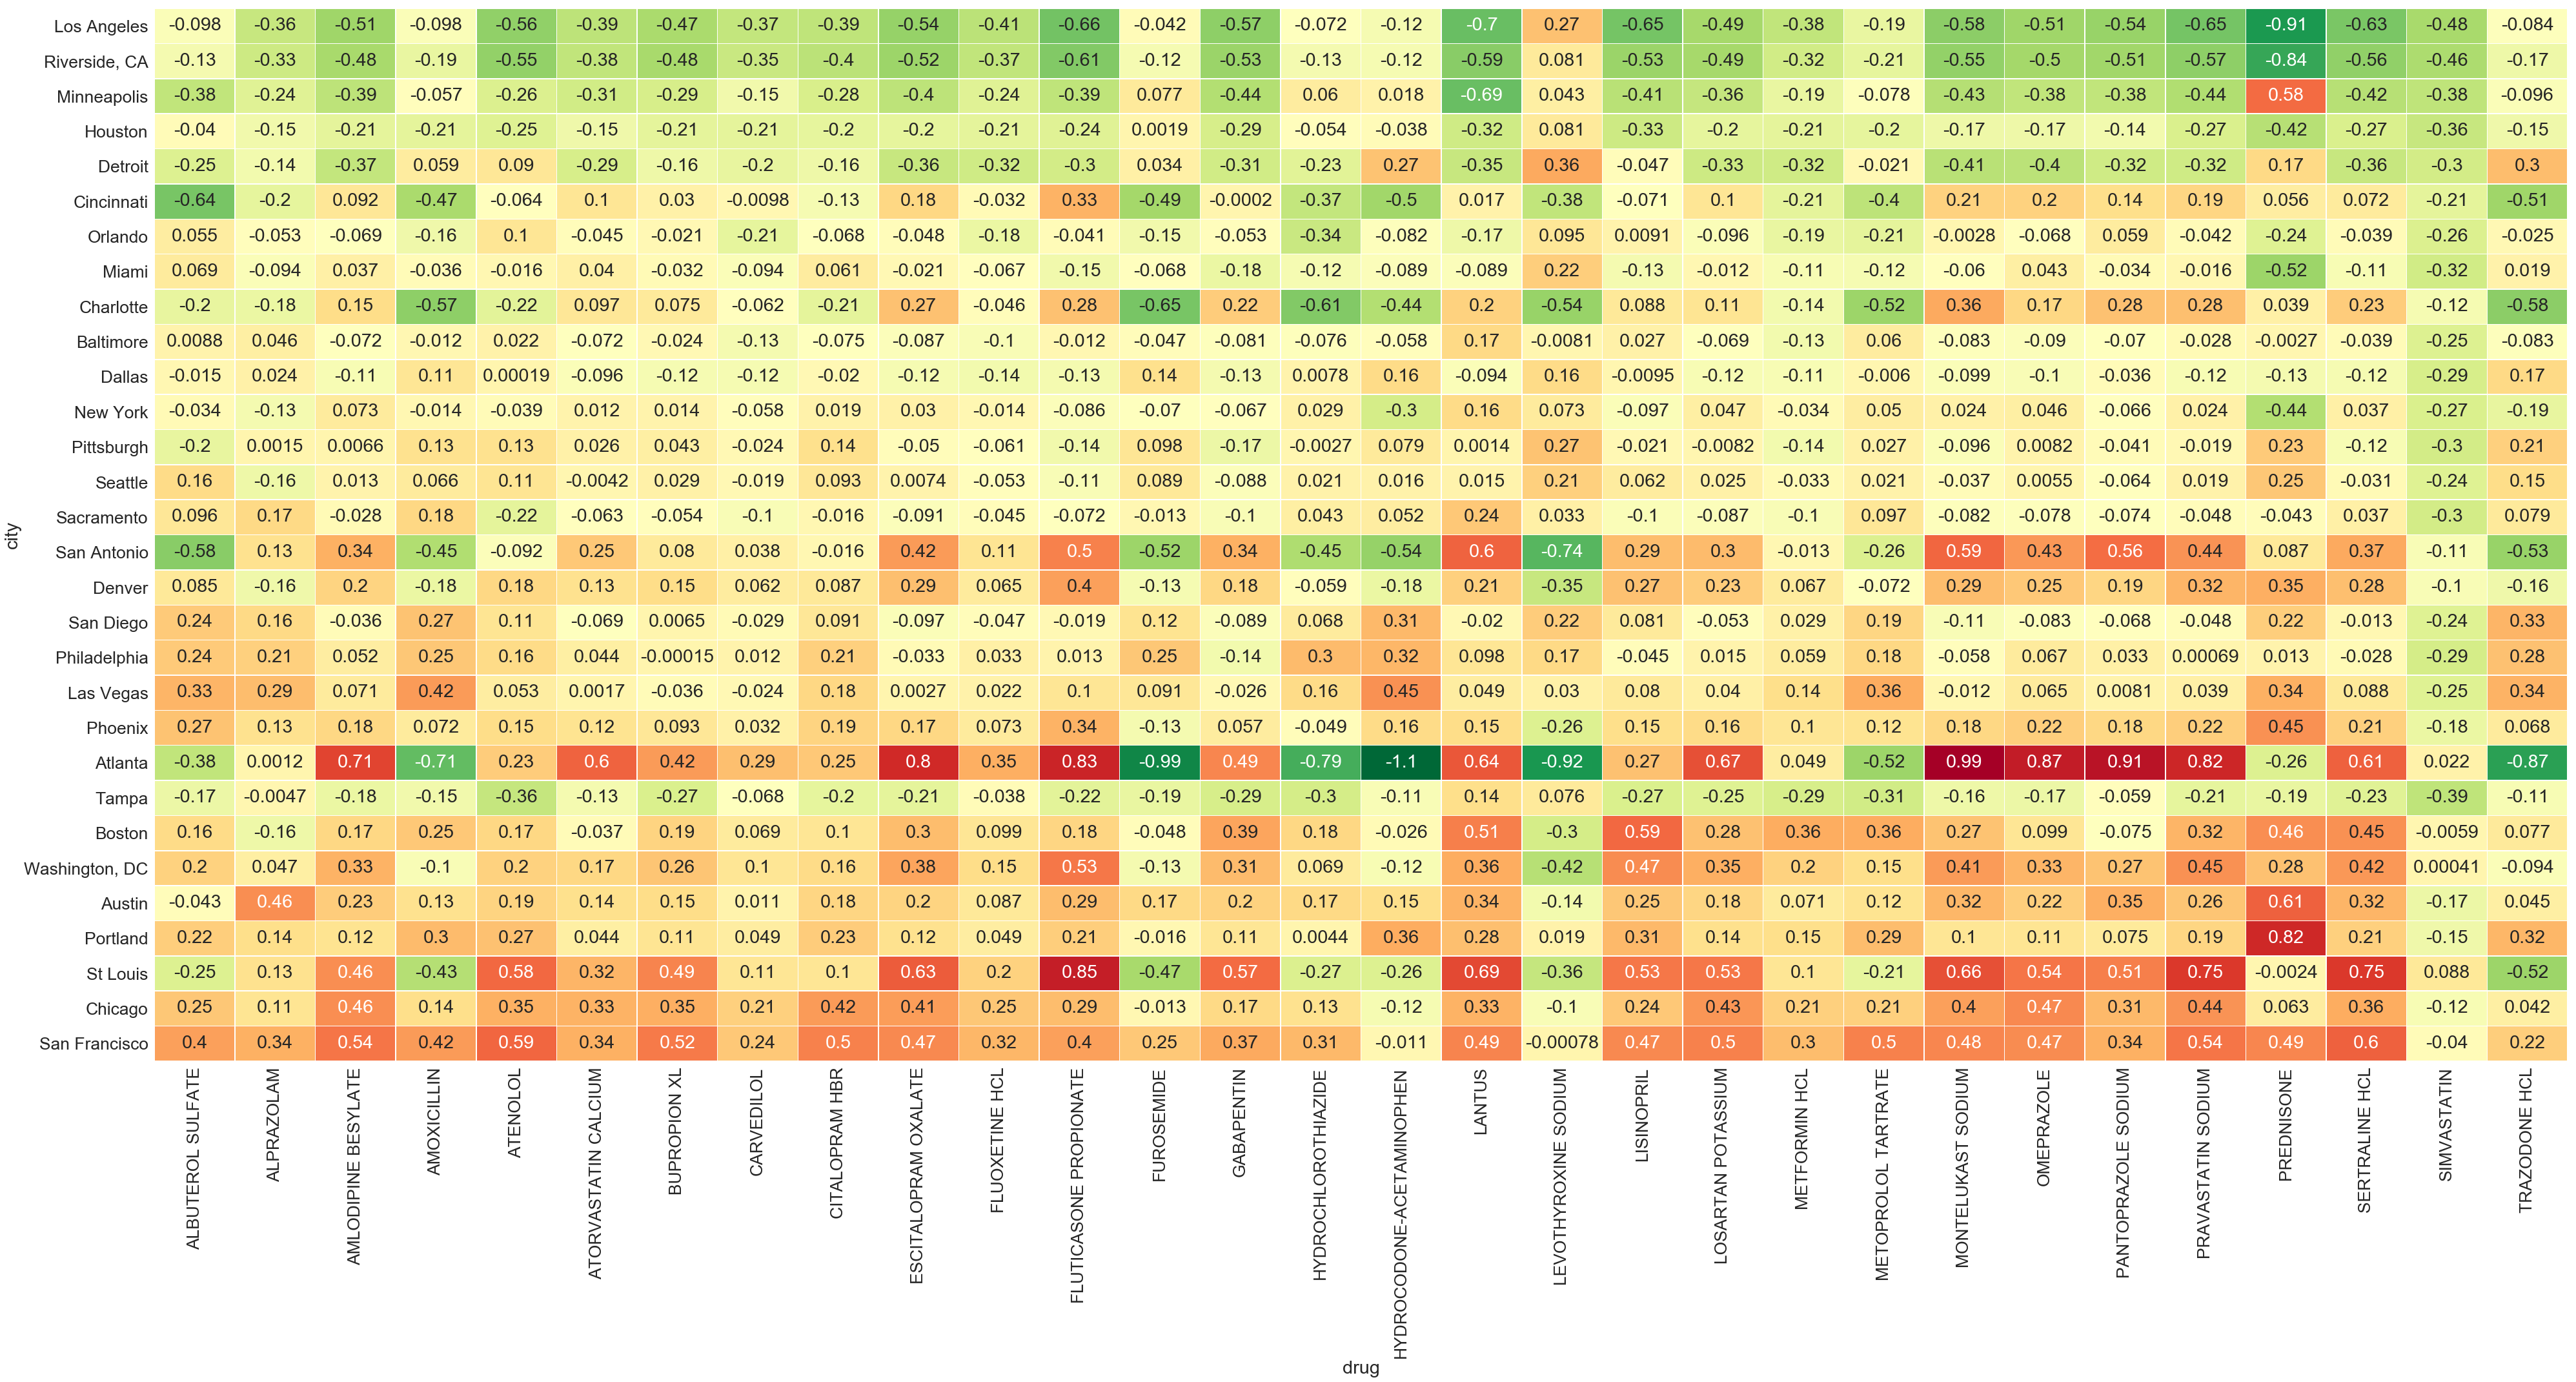

In [9]:
# Construct pivot and heatmap of mean z-scores by city and drug
pivot_index = df.groupby(['city']).mean()['zscore'].sort_values().index
df_pivot = df1.pivot_table(index='city', columns='drug', values='zscore', aggfunc=np.mean)
df_pivot = df_pivot.reindex(labels=list(pivot_index))
plt.figure(figsize = (67,30))
sns.set(font_scale=2.4)
sns.heatmap(df_pivot, annot=True, cmap="RdYlGn_r", linewidths=.5, cbar=False)
plt.show()